# Single cell entrainment quality 
### 1. Overview
It's experimentally shown that when an adaptive spike is elicited by $cAMP_{e}$ stimulation,there exists a refractory period- the stimulation has to be withdrawn for a certain length of time before a second adaptive spike can be elicited by the same input concentration. This feature can be quantified with a entrainment quality heatmap. With different input period and ON time (peak width, Figure 4A), single *Dictyostelium* cells show different degrees of entrainment quality(i.e. how much the subsequent spikes resemble the first spike). 

With this notebook, you can play with different $cAMP_{e}$ input concentrtaions, entrainment period widths, and entrainment peak widths; and visualize single cell response traces ($cAMP_{i}$) as well as entrainment quality heatmaps. By default, period and peak width for each model is sampled from 0.8 ~1.8 and 0.4 ~1.4  times the respective time scale normalization parameter.
![](imgs/FigS4_singlecell_entrainment.png)
<h5><center>Single cell entrainment.</center></h5>

#### Let's start by importing packages and setting up time scaling parameters

In [1]:
import os
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import scipy.io

os.chdir("../compare_models")
from Gregor2010_agent_and_pop_FUN import  Gregor2010_agent
from Sgro2015_agent_and_pop_FUN import Sgro2015_agent
from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_agent_3var
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_agent
from Kamino2017_agent_and_pop_FUN import Kamino2017_agent 

from NB_SC_functions import SC_entrainment, SC_entrainment_plot
# Normalization parameters
from Params import NormParams
for key,val in NormParams.items():
        exec(key + '=val')
os.chdir("../Notebooks") 

### 2. Experimental data 
#### import and plot experimental data (from [Sgro et al. 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352) )

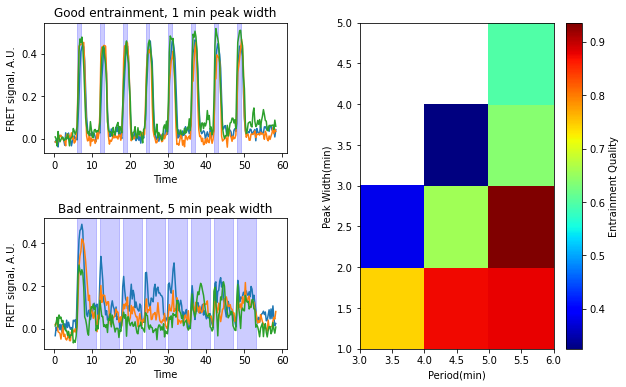

In [2]:
# Sgro2015Figure4 = scipy.io.loadmat('../exp_data/Figure4Data.mat')
Sgro2015Figure4Traces = pd.read_excel(r'../exp_data/Sgro2015DataFormattedforPython.xlsx',
                                     sheet_name='Figure4traces')
HeatmapPeriod = pd.read_excel(r'../exp_data/Sgro2015DataFormattedforPython.xlsx',
                                     sheet_name='Figure4PeriodPkWdth')['Period(min)']
HeatmapPkWdth = pd.read_excel(r'../exp_data/Sgro2015DataFormattedforPython.xlsx',
                                     sheet_name='Figure4PeriodPkWdth')['Peak Width (min)']
Sgro2015Figure4Heatmap = pd.read_excel(r'../exp_data/Sgro2015DataFormattedforPython.xlsx',
                                     sheet_name='Figure4heatmap')
heatmap = Sgro2015Figure4Heatmap.values

fig = plt.figure(figsize=(10,6))
grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.5)
ax1= fig.add_subplot(grid[0, 0])
ax1.plot(Sgro2015Figure4Traces["Time (min)"],Sgro2015Figure4Traces["Cell 1 FRET Trace (1 min pulse)"])
ax1.plot(Sgro2015Figure4Traces["Time (min)"],Sgro2015Figure4Traces["Cell 2 FRET Trace (1 min pulse)"])
ax1.plot(Sgro2015Figure4Traces["Time (min)"],Sgro2015Figure4Traces["Cell 3 FRET Trace (1 min pulse)"])
for i in range(8):
    ax1.axvspan(6+i*6, 7+i*6, alpha=0.2, color='b')
ax1.set_title('Good entrainment, 1 min peak width')
ax1.set_xlabel('Time');ax1.set_ylabel('FRET signal, A.U.')

ax2= fig.add_subplot(grid[1, 0])
ax2.plot(Sgro2015Figure4Traces["Time (min)"],Sgro2015Figure4Traces["Cell 1 FRET Trace (5 min pulse)"])
ax2.plot(Sgro2015Figure4Traces["Time (min)"],Sgro2015Figure4Traces["Cell 2 FRET Trace (5 min pulse)"])
ax2.plot(Sgro2015Figure4Traces["Time (min)"],Sgro2015Figure4Traces["Cell 3 FRET Trace (5 min pulse)"])
for i in range(8):
    ax2.axvspan(6+i*6, 11+i*6, alpha=0.2, color='b')
ax2.set_title('Bad entrainment, 5 min peak width')
ax2.set_xlabel('Time');ax2.set_ylabel('FRET signal, A.U.')

ax3 = fig.add_subplot(grid[:, 1])
# PeriodExp = np.linspace(3, 6, num=4); PkWdthExp = np.linspace(1,5,5)
# entrainmentRs = Sgro2015Figure4["entrainmentRs"][:,0:4]; entrainmentRs[entrainmentRs == 0] = 'nan'=
entrainmentRs = Sgro2015Figure4Heatmap.values; entrainmentRs[entrainmentRs == 0] = 'nan'
heatmap = ax3.pcolor(HeatmapPeriod, HeatmapPkWdth ,np.flip(entrainmentRs,0), cmap='jet') 
#heatmap.set_clim(0,1)
ax3.set_xlabel('Period(min)'); ax3.set_ylabel('Peak Width(min)')
cbar=fig.colorbar(heatmap, ax=ax3);
cbar.set_label( 'Entrainment Quality')
plt.show()

### 3. Receptor desensitization
#### Set up parameters (from Table II in [Matiel & Goldbeter 1987](https://www.sciencedirect.com/science

In [3]:
from NB_SC_functions import  Goldbeter1986_SC
from Params import Goldbeter3AgentParam

#### Define entrainment period and peak width (ON time in each period) screening array and get stimulated response
Optional: visualize $cAMP_{i}$ responses of defined periods and peak widths

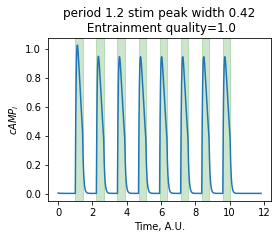

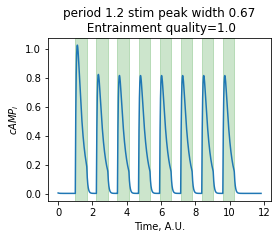

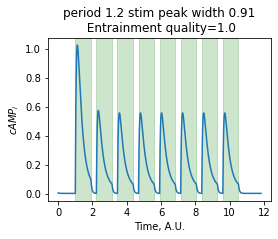

In [4]:
period_space_Gold =np.linspace(0.8,1.8,num=8) # period of cAMPe stim 
PkWdth_space_Gold = np.linspace(0.3, 1.4, num=10) # peak width of cAMP stim


dt=0.001 ; 
cAMP = 1 # extracellular cAMP
NumofCycle = 8
# define which traces to plot, 1st column defines the index of the period, 
# 2nd column defines the index of the peak width
single_trace_to_plot = np.array([[3,1],[3,3], [3,5]])
MeanR_Gold = SC_entrainment(period_space_Gold, PkWdth_space_Gold, NumofCycle, cAMP, 
                            Nt_Goldbeter, Nh_Goldbeter, dt, single_trace_to_plot, 
                            Goldbeter1986_SC,Goldbeter3AgentParam )

#### Plot entrainment quality heatmap with specified color limits

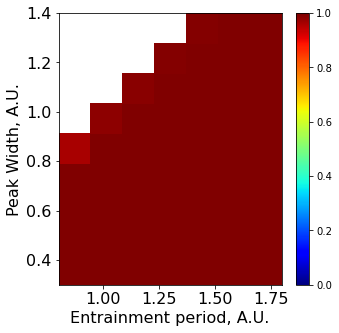

In [5]:
clim = [0,1] # color limit of the colorbar
SC_entrainment_plot(period_space_Gold, PkWdth_space_Gold,MeanR_Gold,clim)


### 4. CDINFB
#### Set up parameters (from supplementary in [Maeda et al. 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [6]:
from NB_SC_functions import Maeda2004_SC
from Params import MaedaAgentParam

#### Define entrainment period and peak width (ON time in each period) screening array
Optional: visualize $cAMP_{i}$ responses of defined periods and peak widths

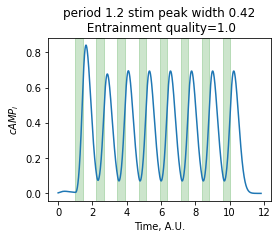

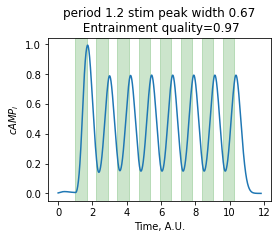

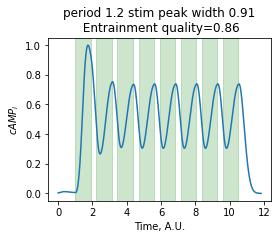

In [7]:
period_space_Maeda = np.linspace(0.8,1.8,num=8) # period of cAMPe stim 
PkWdth_space_Maeda =  np.linspace(0.3, 1.4, num=10) # peak width of cAMP stim


dt=0.001 ; # t_tot=20*Nt; t=list(np.arange(0,t_tot,dt))
cAMP = 1 # extracellular cAMP
NumofCycle = 8
# define which traces to plot, 1st column defines the index of the period, 
# 2nd column defines the index of the peak width
single_trace_to_plot = np.array([[3,1],[3,3], [3,5]])
MeanR_Maeda = SC_entrainment(period_space_Maeda, PkWdth_space_Maeda, NumofCycle, cAMP, 
                            Nt_Maeda,Nh_Maeda, dt, single_trace_to_plot, 
                            Maeda2004_SC,MaedaAgentParam )

#### Plot entrainment quality heatmap with specified color limits

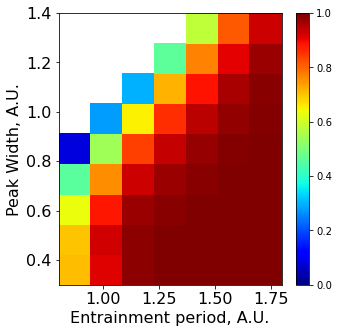

In [8]:
clim = [0,1] # color limit of the colorbar
SC_entrainment_plot(period_space_Maeda, PkWdth_space_Maeda,MeanR_Maeda,clim)

### 5. IPNFB
#### Set up parameters

In [9]:
from Params import SgroAgentParam
from NB_SC_functions import Sgro2015_SC

#### Define entrainment period and peak width (ON time in each period) screening array
Optional: visualize $cAMP_{i}$ responses of defined periods and peak widths

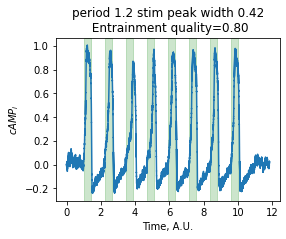

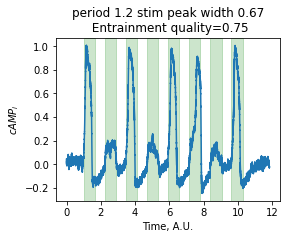

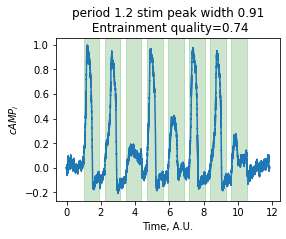

In [10]:
period_space_Sgro = np.linspace(0.8,1.8,num=8) # period of cAMPe stim 
PkWdth_space_Sgro =  np.linspace(0.3, 1.4, num=10) # peak width of cAMP stim


dt=0.001; # t_tot=20*Nt; t=list(np.arange(0,t_tot,dt))
cAMP = 1 # extracellular cAMP
NumofCycle = 8
# define which traces to plot, 1st column defines the index of the period, 
# 2nd column defines the index of the peak width
single_trace_to_plot = np.array([[3,1],[3,3], [3,5]])
MeanR_Sgro = SC_entrainment(period_space_Sgro, PkWdth_space_Sgro, NumofCycle, cAMP, 
                            Nt_Sgro, Nh_Sgro, dt, single_trace_to_plot, 
                            Sgro2015_SC,SgroAgentParam, Nh_Sgro_offset)

#### Plot entrainment quality heatmap with specified color limits

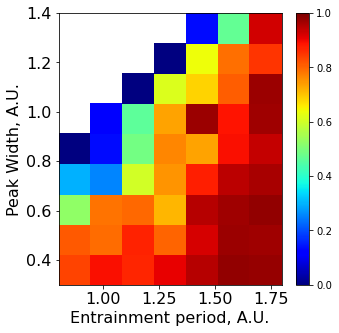

In [11]:
clim = [0,1] # color limit of the colorbar
SC_entrainment_plot(period_space_Sgro, PkWdth_space_Sgro,MeanR_Sgro,clim)

### 7. IFFL
#### Set up parameters

In [12]:
from Params import KaminoAgentParam
from NB_SC_functions import Kamino2017_SC

#### Define entrainment period and peak width (ON time in each period) screening array
Optional: visualize $cAMP_{i}$ responses of defined periods and peak widths

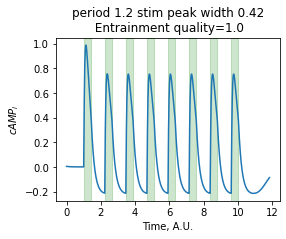

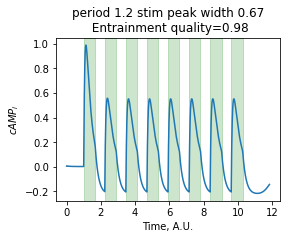

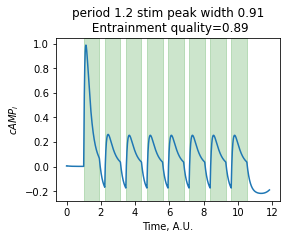

In [13]:
period_space_Kamino = np.linspace(0.8,1.8,num=8) # period of cAMPe stim 
PkWdth_space_Kamino =  np.linspace(0.3, 1.4, num=10) # peak width of cAMP stim


dt=0.001 ; # t_tot=20*Nt; t=list(np.arange(0,t_tot,dt))
cAMP = 1 # extracellular cAMP
NumofCycle = 8
# define which traces to plot, 1st column defines the index of the period, 
# 2nd column defines the index of the peak width
single_trace_to_plot = np.array([[3,1],[3,3], [3,5]])
MeanR_Kamino = SC_entrainment(period_space_Kamino, PkWdth_space_Kamino, NumofCycle, cAMP, 
                            Nt_Kamino, Nh_Kamino, dt, single_trace_to_plot, 
                            Kamino2017_SC, KaminoAgentParam, Nh_Kamino_offset)

#### Plot entrainment quality heatmap with specified color limits

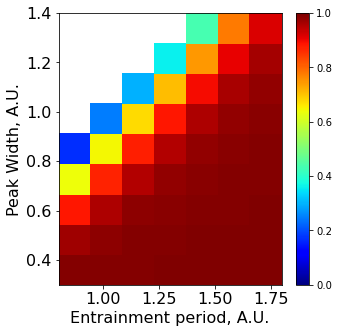

In [14]:
clim = [0,1] # color limit of the colorbar
SC_entrainment_plot(period_space_Kamino, PkWdth_space_Kamino,MeanR_Kamino,clim)
